# Initialize Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as f
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [2]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext

# Import Data, Inspect Columns

In [70]:
df = spark.read.option("inferSchema", "true").csv('train_ver2.csv', header = True)

In [4]:
df.columns

['fecha_dato',
 'ncodpers',
 'ind_empleado',
 'pais_residencia',
 'sexo',
 'age',
 'fecha_alta',
 'ind_nuevo',
 'antiguedad',
 'indrel',
 'ult_fec_cli_1t',
 'indrel_1mes',
 'tiprel_1mes',
 'indresi',
 'indext',
 'conyuemp',
 'canal_entrada',
 'indfall',
 'tipodom',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'renta',
 'segmento',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

The columns are in Spanish and are a little bit vague. I'm going to rename all of them (except for age :))

In [71]:
df = df.withColumnRenamed("fecha_dato", "Date")\
    .withColumnRenamed("ncodpers", "Customer_Code")\
    .withColumnRenamed("ind_empleado", "Employee_Index")\
    .withColumnRenamed("pais_residencia", "Country_Residence")\
    .withColumnRenamed("fecha_alta", "Join_Date")\
    .withColumnRenamed("ind_nuevo", "New_customer")\
    .withColumnRenamed("sexo", "Gender")\
    .withColumnRenamed("canal_entrada", "Channel")\
    .withColumnRenamed("antiguedad", "Months_at_Bank")\
    .withColumnRenamed("indrel", "Customer_during_Month")\
    .withColumnRenamed("ult_fec_cli_1t", "Stopped_Being_Customer")\
    .withColumnRenamed("indrel_1mes", "Customer_Type")\
    .withColumnRenamed("tiprel_1mes", "Relationship_to_Bank")\
    .withColumnRenamed("indresi", "Residence_Index")\
    .withColumnRenamed("indext", "Foreigner_Index")\
    .withColumnRenamed("conyuemp", "Spouse_Index")\
    .withColumnRenamed("indfall", "Deceased_Index")\
    .withColumnRenamed("tipodom", "Address_Type")\
    .withColumnRenamed("cod_prov", "Province_Code")\
    .withColumnRenamed("nomprov", "Province_Name")\
    .withColumnRenamed("ind_actividad_cliente", "Active")\
    .withColumnRenamed("renta", "Income")\
    .withColumnRenamed("segmento", "Segmentation")\
    .withColumnRenamed("ind_ahor_fin_ult1", "Savings_Account")\
    .withColumnRenamed("ind_aval_fin_ult1", "Guarantees")\
    .withColumnRenamed("ind_cco_fin_ult1", "Current_Accounts")\
    .withColumnRenamed("ind_cder_fin_ult1", "Derivative")\
    .withColumnRenamed("ind_cno_fin_ult1", "Payroll_Account")\
    .withColumnRenamed("ind_ctju_fin_ult1", "Junior_Account")\
    .withColumnRenamed("ind_ctma_fin_ult1", "More_Particular_Account")\
    .withColumnRenamed("ind_ctop_fin_ult1", "Particular_Account")\
    .withColumnRenamed("ind_ctpp_fin_ult1", "Particular_Plus_Account")\
    .withColumnRenamed("ind_deco_fin_ult1", "Short_Term_Deposits")\
    .withColumnRenamed("ind_deme_fin_ult1", "Medium_Term_Deposits")\
    .withColumnRenamed("ind_dela_fin_ult1", "Long_Term_Deposits")\
    .withColumnRenamed("ind_ecue_fin_ult1", "e-Account")\
    .withColumnRenamed("ind_fond_fin_ult1", "Funds")\
    .withColumnRenamed("ind_hip_fin_ult1", "Mortgage")\
    .withColumnRenamed("ind_plan_fin_ult1", "Pensions")\
    .withColumnRenamed("ind_pres_fin_ult1", "Loans")\
    .withColumnRenamed("ind_reca_fin_ult1", "Taxes")\
    .withColumnRenamed("ind_tjcr_fin_ult1", "Credit_Card")\
    .withColumnRenamed("ind_valo_fin_ult1", "Securities")\
    .withColumnRenamed("ind_viv_fin_ult1", "Home_Account")\
    .withColumnRenamed("ind_nomina_ult1", "Payroll")\
    .withColumnRenamed("ind_nom_pens_ult1", "Pensions_two")\
    .withColumnRenamed("ind_recibo_ult1", "Direct_Debit")
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Customer_Code: double (nullable = true)
 |-- Employee_Index: string (nullable = true)
 |-- Country_Residence: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- Join_Date: string (nullable = true)
 |-- New_customer: string (nullable = true)
 |-- Months_at_Bank: string (nullable = true)
 |-- Customer_during_Month: string (nullable = true)
 |-- Stopped_Being_Customer: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Relationship_to_Bank: string (nullable = true)
 |-- Residence_Index: string (nullable = true)
 |-- Foreigner_Index: string (nullable = true)
 |-- Spouse_Index: string (nullable = true)
 |-- Channel: string (nullable = true)
 |-- Deceased_Index: string (nullable = true)
 |-- Address_Type: string (nullable = true)
 |-- Province_Code: string (nullable = true)
 |-- Province_Name: string (nullable = true)
 |-- Active: string (nullable = true)
 |-- Income: dou

Some of the feature columns appear to be redundant:

In [72]:
df = df.drop(df.Province_Code)

Residence_Index and Foreigner_Index are inverses of each other; we don't need both

In [73]:
df = df.drop(df.Residence_Index) 

Inspect the data for NANs and Null values:

In [8]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           df.columns]).toPandas().T


,0
Date,0
Customer_Code,0
Employee_Index,27734
Country_Residence,27734
Gender,27804
age,0
Join_Date,27734
New_customer,0
Months_at_Bank,0
Customer_during_Month,0


The good news is that there are no NAN values, and that there are no null values for any of the product columns. The bad news is that 15 of the 22 feature columns in the training set have null values.

 ##  Highlighting Columns and Imputing Values

#### Customer_Code 

In [9]:
ccgroup = df.groupBy('Customer_Code').count()
df.groupBy('Customer_Code').count().show()

+-------------+-----+
|Customer_Code|count|
+-------------+-----+
|    1050599.0|   17|
|    1052358.0|   10|
|    1052187.0|   17|
|    1048934.0|   15|
|    1048839.0|   17|
|    1049108.0|   17|
|    1048792.0|   17|
|    1048656.0|   17|
|    1049799.0|   17|
|    1049905.0|   17|
|    1049944.0|   17|
|    1056294.0|   17|
|    1055185.0|   17|
|    1055633.0|   17|
|    1055721.0|   17|
|    1055528.0|   17|
|    1056869.0|   17|
|    1056843.0|   17|
|    1056723.0|   17|
|    1056566.0|   17|
+-------------+-----+
only showing top 20 rows



In [10]:
cc_countdf = df.groupBy('Customer_Code').count()

In [11]:
cc_full = cc_countdf.filter("count==17")
cc_incomplete = cc_countdf.filter("count!=17")

In [12]:
cc_full.count()

605464

In [13]:
cc_incomplete.count()

351181

Each individual customer has up to 17 observations, which coincides with the 17 months that the dataset measures. We do not want customers with less than 17 observations because we want to look at the same, full range of months for every customer to best optimize our collaborative filtering system. Luckily, we have over 600,000 customers with a full range of data.

In [14]:
#deleteccs = cc_incomplete.select("Customer_Code").rdd.flatMap(lambda x: x).collect()

In [15]:
#df = df.filter(~f.col("Customer_Code").isin(deleteccs))

#### Employee_Index

In [9]:
df.groupBy('Employee_Index').count().show()

+--------------+--------+
|Employee_Index|   count|
+--------------+--------+
|             F|    2523|
|          null|   27734|
|             B|    3566|
|             A|    2492|
|             N|13610977|
|             S|      17|
+--------------+--------+



In [74]:
#No variation
df = df.drop(df.Employee_Index) 

#### Country_Residence

In [11]:
df.groupBy('Country_Residence').count().orderBy(col("count").desc()).show()

+-----------------+--------+
|Country_Residence|   count|
+-----------------+--------+
|               ES|13553710|
|             null|   27734|
|               FR|    5161|
|               AR|    4835|
|               DE|    4625|
|               GB|    4605|
|               US|    3651|
|               CO|    3526|
|               IT|    2947|
|               RO|    2931|
|               MX|    2573|
|               BR|    2351|
|               VE|    2331|
|               EC|    2169|
|               CH|    1995|
|               BE|    1526|
|               BO|    1514|
|               PY|    1430|
|               PT|    1419|
|               CL|     989|
+-----------------+--------+
only showing top 20 rows



In [75]:
##Not enough values in non-Spain Countries to justify this column. Will use 'Foreigner Index' instead
df = df.drop(df.Country_Residence) 

#### Gender 

In [13]:
df.groupBy('Gender').count().orderBy(col("count").desc()).show()

+------+-------+
|Gender|  count|
+------+-------+
|     V|7424252|
|     H|6195253|
|  null|  27804|
+------+-------+



In [76]:
from pyspark.sql.functions import regexp_replace
df = df.withColumn('Gender', regexp_replace('Gender', 'V', 'Female'))
df = df.withColumn('Gender', regexp_replace('Gender', 'H', 'Male'))

#### Age

In [15]:
df.groupBy('age').count().orderBy(col("count").desc()).show()

+---+------+
|age| count|
+---+------+
| 23|779884|
| 22|736314|
| 24|734785|
| 21|675988|
| 25|472016|
| 20|422867|
| 26|347778|
| 43|324303|
| 44|322955|
| 42|319713|
| 45|314771|
| 41|309051|
| 46|299365|
| 40|287754|
| 47|286505|
| 27|281981|
| 48|271576|
| 39|260548|
| 49|250484|
| 28|240192|
+---+------+
only showing top 20 rows



In [77]:
from pyspark.sql.types import IntegerType
df = df.withColumn("Age", df["age"].cast(IntegerType()))

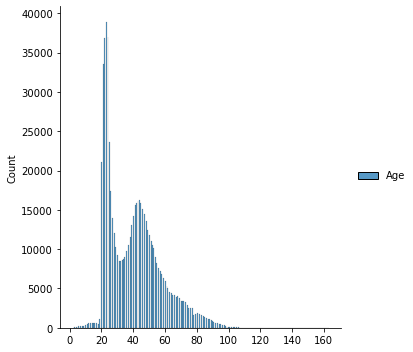

In [17]:
import seaborn as sns
agedf = df.select(['Age']).sample(False, .05, 42)
agedf = agedf.toPandas()
sns.displot(agedf)

In [18]:
# find the median
df.approxQuantile("Age", [0.5], 0.02)

[39.0]

In [78]:
#impute the median
df = df.na.fill(value=39,subset=["Age"])

In [79]:
###Bin Age into groups
def Age_Range(Age):
    if Age < 13:
        return '0-12'
    elif Age > 12 and Age < 18:
        return '13-17'
    elif Age > 17 and Age < 25:
        return '18-24'
    elif Age > 24 and Age < 41:
        return '25-40'
    elif Age > 40 and Age < 66:
        return '41-65'
    elif Age > 65 :
        return '66+'
udf_Age = udf(Age_Range, StringType())
df = df.withColumn("Age_Range", udf_Age('Age'))

In [21]:
df.groupBy('Age_Range').count().show()

+---------+-------+
|Age_Range|  count|
+---------+-------+
|    25-40|3818707|
|    41-65|5065353|
|    13-17|  62242|
|    18-24|3382424|
|      66+|1262029|
|     0-12|  56554|
+---------+-------+



In [80]:
df = df.drop(df.Age) 

#### Join Date

In [23]:
df.groupBy('Join_Date').count().orderBy(col("count").desc()).show()

+----------+-----+
| Join_Date|count|
+----------+-----+
|2014-07-28|57389|
|2014-10-03|54287|
|2014-08-04|45746|
|2013-10-14|40804|
|2013-08-03|33414|
|      null|27734|
|2012-08-06|26223|
|2014-07-21|26027|
|2012-08-03|25409|
|2012-08-02|25004|
|2013-10-11|24751|
|2013-08-10|23766|
|2012-08-01|22935|
|2014-09-17|22810|
|2014-08-06|22756|
|2014-09-24|22696|
|2014-07-30|22695|
|2012-08-09|22433|
|2013-07-22|22309|
|2012-08-07|22052|
+----------+-----+
only showing top 20 rows



In [81]:
##Seems like it won't be a great predictive factor.Other variables measure how long someone has been at the bank
df = df.drop(df.Join_Date) 

# 

#### New_customer

In [25]:
df.groupBy('New_customer').count().orderBy(col("count").desc()).show()

+------------+--------+
|New_customer|   count|
+------------+--------+
|           0|12808368|
|           1|  811207|
|          NA|   27734|
+------------+--------+



In [82]:
#Will stick with the Months_at_Bank feature for now
df = df.drop(df.New_customer) 

#### Months_at_Bank

In [16]:
df = df.withColumn("Months_at_Bank", df["Months_at_Bank"].cast(IntegerType()))

In [17]:
df.groupBy('Months_at_Bank').count().orderBy(col("Months_at_Bank")).show()

+--------------+------+
|Months_at_Bank| count|
+--------------+------+
|          null| 27734|
|       -999999|    38|
|             0|134484|
|             1|132579|
|             2|130259|
|             3|132745|
|             4|127442|
|             5|139618|
|             6|127176|
|             7|129262|
|             8|155703|
|             9|177957|
|            10|206165|
|            11|124718|
|            12|243160|
|            13|123990|
|            14|126798|
|            15|121716|
|            16|135307|
|            17|125055|
+--------------+------+
only showing top 20 rows



#### Customer_during_Month

In [29]:
df.groupBy('Customer_during_Month').count().show()

+---------------------+--------+
|Customer_during_Month|   count|
+---------------------+--------+
|                   NA|   27734|
|                   99|   24793|
|                    1|13594782|
+---------------------+--------+



In [83]:
#Same as active
df = df.drop(df.Customer_during_Month) 

#### Spouse_Index 

In [30]:
df.groupBy('Spouse_Index').count().orderBy(col("count").desc()).show()

+------------+--------+
|Spouse_Index|   count|
+------------+--------+
|        null|13645501|
|           N|    1791|
|           S|      17|
+------------+--------+



In [84]:
#Almost entirely null values
df = df.drop(df.Spouse_Index) 

#### Stopped_Being_Customer 

In [85]:
df = df.drop(df.Stopped_Being_Customer) 

#### Channel  

In [33]:
df.groupBy('Channel').count().orderBy(col("count").desc()).show()

+-------+-------+
|Channel|  count|
+-------+-------+
|    KHE|4055270|
|    KAT|3268209|
|    KFC|3098360|
|    KHQ| 591039|
|    KFA| 409669|
|    KHK| 241084|
|   null| 186126|
|    KHM| 183924|
|    KHD| 116891|
|    KHN| 116608|
|    KAS|  86221|
|    RED|  75607|
|    KAG|  74295|
|    KAY|  67350|
|    KAA|  66656|
|    KAB|  62381|
|    KAE|  50764|
|    KCC|  49308|
|    KBZ|  46446|
|    KHL|  45128|
+-------+-------+
only showing top 20 rows



Will decide what to do about null values after further inspection...

#### Customer_Type 

In [34]:
df.groupBy('Customer_Type').count().orderBy(col("count").desc()).show()

+-------------+-------+
|Customer_Type|  count|
+-------------+-------+
|          1.0|9133383|
|            1|4357298|
|         null| 149781|
|          3.0|   2780|
|            3|   1570|
|            P|    874|
|          2.0|    740|
|            2|    577|
|          4.0|    223|
|            4|     83|
+-------------+-------+



In [86]:
#No variation
df = df.drop(df.Customer_Type) 

#### Relationship_to_Bank 

In [36]:
df.groupBy('Relationship_to_Bank').count().orderBy(col("count").desc()).show()

+--------------------+-------+
|Relationship_to_Bank|  count|
+--------------------+-------+
|                   I|7304875|
|                   A|6187123|
|                null| 149781|
|                   P|   4656|
|                   R|    870|
|                   N|      4|
+--------------------+-------+



In [87]:
##Active Index is a better metric
df = df.drop(df.Relationship_to_Bank) 

#### Foreigner_Index 

In [38]:
df.groupBy('Foreigner_Index').count().orderBy(col("count").desc()).show()

+---------------+--------+
|Foreigner_Index|   count|
+---------------+--------+
|              N|12974839|
|              S|  644736|
|           null|   27734|
+---------------+--------+



In [88]:
##Impute Highest Frequency Value
df = df.na.fill(value='N',subset=["Foreigner_Index"])

#### Address_Type 

In [40]:
df.groupBy('Address_Type').count().orderBy(col("count").desc()).show()

+------------+--------+
|Address_Type|   count|
+------------+--------+
|           1|13619574|
|          NA|   27735|
+------------+--------+



In [98]:
#No variation
df = df.drop(df.Address_Type) 

#### Province_Name

In [42]:
df.groupBy('Province_Name').count().orderBy(col("count").desc()).show()

+-------------+-------+
|Province_Name|  count|
+-------------+-------+
|       MADRID|4409600|
|    BARCELONA|1275219|
|     VALENCIA| 682304|
|      SEVILLA| 605164|
|    CORUÑA, A| 429322|
|       MURCIA| 396759|
|       MALAGA| 367023|
|     ZARAGOZA| 342543|
|     ALICANTE| 313397|
|        CADIZ| 294684|
|   PONTEVEDRA| 280026|
|     ASTURIAS| 265749|
|   VALLADOLID| 238259|
|  PALMAS, LAS| 235700|
|      BADAJOZ| 192996|
|      BIZKAIA| 185888|
|       TOLEDO| 183067|
|      GRANADA| 178562|
|    SALAMANCA| 164238|
|    CANTABRIA| 155706|
+-------------+-------+
only showing top 20 rows



Will decide what to do about null values upon further inspection...

#### Deceased_Index

In [43]:
df.groupBy('Deceased_Index').count().orderBy(col("count").desc()).show()

+--------------+--------+
|Deceased_Index|   count|
+--------------+--------+
|             N|13584813|
|             S|   34762|
|          null|   27734|
+--------------+--------+



In [89]:
#Deceased implies that a user is inactive, so it's redundant for our task
df = df.drop(df.Deceased_Index) 

#### Active 

In [45]:
df.groupBy('Active').count().orderBy(col("count").desc()).show()

+------+-------+
|Active|  count|
+------+-------+
|     0|7384390|
|     1|6235185|
|    NA|  27734|
+------+-------+



In [90]:
df = df.na.fill(value=0 ,subset=["Active"])

#### Income 

In [47]:
df.groupBy('Income').count().orderBy(col("Income").desc()).show()

+--------------------+-----+
|              Income|count|
+--------------------+-----+
|       2.889439551E7|   75|
|       2.554725192E7|   17|
|       2.425323693E7|   28|
|       2.372006655E7|   45|
|       2.203473876E7|   96|
|        2.17241865E7|   11|
|       2.167424667E7|   26|
|       1.984933197E7|   17|
|        1.78040481E7|   17|
|       1.601867784E7|   17|
|       1.595737164E7|   17|
|       1.571171646E7|   55|
|1.4337025919999998E7|   11|
|       1.326862128E7|   68|
|       1.190087151E7|   17|
|       1.185785646E7|   34|
|       1.180401498E7|   17|
|       1.141151727E7|   84|
|       1.138152603E7|   11|
|       1.134115248E7|   51|
+--------------------+-----+
only showing top 20 rows



In [48]:
df.groupBy('Income').count().orderBy(col("Income")).show()

+-----------------+-------+
|           Income|  count|
+-----------------+-------+
|             null|2794375|
|          1202.73|     17|
|          1471.23|     17|
|          2336.01|     11|
|           2539.8|     17|
|          3731.79|     10|
|          3796.86|     50|
|4559.549999999998|     17|
|          5040.39|     11|
|           5130.0|     17|
|          5163.75|     34|
|          5340.93|     28|
|          5437.62|     34|
|5651.549999999998|     17|
|          5925.54|      9|
|6070.200000000002|     17|
|          6273.06|     17|
|6313.200000000002|     17|
|           6360.0|     17|
|          6480.66|     17|
+-----------------+-------+
only showing top 20 rows



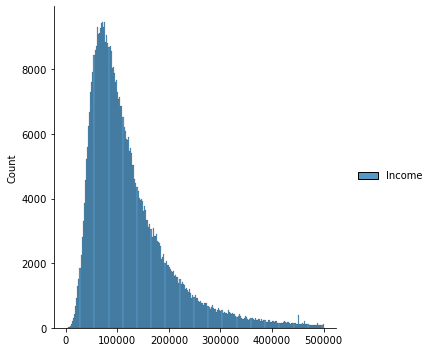

In [28]:
incomesubset = df.filter(df.Income < 500000)
incomedf = incomesubset.select(['Income']).sample(False, 0.05, 42)
incomedf = incomedf.toPandas()
sns.displot(incomedf)

In [49]:
# find the median
df.approxQuantile("Income", [0.5], 0.02)

[100944.84]

In [91]:
#impute the median
df = df.na.fill(value=100944.84,subset=["Income"])

In [92]:
##Bin Income into groups
def Income(Income):
    if   Income<20000: return '0-20,000'
    elif Income>=20000 and Income<50000: return '20,000-50,000'
    elif Income>=50000 and Income<100000: return '50,000-100,000'
    elif Income>=100000 and Income<160000: return '100,000-160,000'
    elif Income>=160000 and Income<300000: return '160,000-300,000'
    elif Income>=300000 : return '300,000+'
udf_Income = udf(Income, StringType())
df = df.withColumn("Income_Range", udf_Income('Income'))

In [31]:
df.groupBy('Income_Range').count().show()

+---------------+-------+
|   Income_Range|  count|
+---------------+-------+
|       0-20,000|  36298|
|       300,000+| 587435|
|100,000-160,000|5763612|
|  20,000-50,000|1113518|
|160,000-300,000|1997342|
| 50,000-100,000|4149104|
+---------------+-------+



In [93]:
df = df.drop(df.Income) 

#### Segmentation 

In [54]:
df.groupBy('Segmentation').count().orderBy(col("count")).show()

+------------------+-------+
|      Segmentation|  count|
+------------------+-------+
|              null| 189368|
|          01 - TOP| 562142|
|03 - UNIVERSITARIO|4935579|
| 02 - PARTICULARES|7960220|
+------------------+-------+



In [94]:
df = df.na.fill(value=0 ,subset=["Segmentation"])

#### Payroll 

In [56]:
df.groupBy('Payroll').count().orderBy(col("count")).show()

+-------+--------+
|Payroll|   count|
+-------+--------+
|     NA|   16063|
|      1|  745961|
|      0|12885285|
+-------+--------+



In [95]:
df = df.na.fill(value=0 ,subset=["Payroll"])

#### Pensions_two 

In [58]:
df.groupBy('Pensions_two').count().orderBy(col("count")).show()

+------------+--------+
|Pensions_two|   count|
+------------+--------+
|          NA|   16063|
|           1|  810085|
|           0|12821161|
+------------+--------+



In [96]:
df = df.na.fill(value=0 ,subset=["Pensions_two"])

In [99]:
df.columns

['Date',
 'Customer_Code',
 'Gender',
 'Months_at_Bank',
 'Foreigner_Index',
 'Channel',
 'Province_Name',
 'Active',
 'Segmentation',
 'Savings_Account',
 'Guarantees',
 'Current_Accounts',
 'Derivative',
 'Payroll_Account',
 'Junior_Account',
 'More_Particular_Account',
 'Particular_Account',
 'Particular_Plus_Account',
 'Short_Term_Deposits',
 'Medium_Term_Deposits',
 'Long_Term_Deposits',
 'e-Account',
 'Funds',
 'Mortgage',
 'Pensions',
 'Loans',
 'Taxes',
 'Credit_Card',
 'Securities',
 'Home_Account',
 'Payroll',
 'Pensions_two',
 'Direct_Debit',
 'Age_Range',
 'Income_Range']

# EDA 

In [100]:
#Split dataframe so that we have data from the first month and data from the last month
start = df.filter("Date=='2015-01-28'")
end = df.filter("Date=='2016-05-28'")

In [63]:
start.groupBy('Savings_Account').count().show()

+---------------+------+
|Savings_Account| count|
+---------------+------+
|              1|    88|
|              0|625369|
+---------------+------+



In [64]:
end.groupBy('Savings_Account').count().show()

+---------------+------+
|Savings_Account| count|
+---------------+------+
|              1|    78|
|              0|931375|
+---------------+------+



In [101]:
start.groupBy('Guarantees').count().show()

+----------+------+
|Guarantees| count|
+----------+------+
|         1|    19|
|         0|625438|
+----------+------+



In [102]:
end.groupBy('Guarantees').count().show()

+----------+------+
|Guarantees| count|
+----------+------+
|         1|    16|
|         0|931437|
+----------+------+



In [103]:
start.groupBy('Current_Accounts').count().show()

+----------------+------+
|Current_Accounts| count|
+----------------+------+
|               1|487855|
|               0|137602|
+----------------+------+



In [104]:
end.groupBy('Current_Accounts').count().show()

+----------------+------+
|Current_Accounts| count|
+----------------+------+
|               1|561615|
|               0|369838|
+----------------+------+



In [105]:
start.groupBy('Derivative').count().show()

+----------+------+
|Derivative| count|
+----------+------+
|         1|   301|
|         0|625156|
+----------+------+



In [106]:
end.groupBy('Derivative').count().show()

+----------+------+
|Derivative| count|
+----------+------+
|         1|   316|
|         0|931137|
+----------+------+



In [107]:
start.groupBy('Payroll_Account').count().show()

+---------------+------+
|Payroll_Account| count|
+---------------+------+
|              1| 58763|
|              0|566694|
+---------------+------+



In [108]:
end.groupBy('Payroll_Account').count().show()

+---------------+------+
|Payroll_Account| count|
+---------------+------+
|              1| 73061|
|              0|858392|
+---------------+------+



In [109]:
start.groupBy('Junior_Account').count().show()

+--------------+------+
|Junior_Account| count|
+--------------+------+
|             1|  7757|
|             0|617700|
+--------------+------+



In [110]:
end.groupBy('Junior_Account').count().show()

+--------------+------+
|Junior_Account| count|
+--------------+------+
|             1|  7581|
|             0|923872|
+--------------+------+



In [33]:
df.write.csv('santander_df_cleaned.csv')